# EXP_16_super_resolution



### Super Resolution 이란??

😆 Super Resolution이란 저해상도 영상을 고해상도 영상으로 변환하는 작업 또는 그러한 과정을 말합니다


### Super Resolution을 어렵게 만드는 요인들

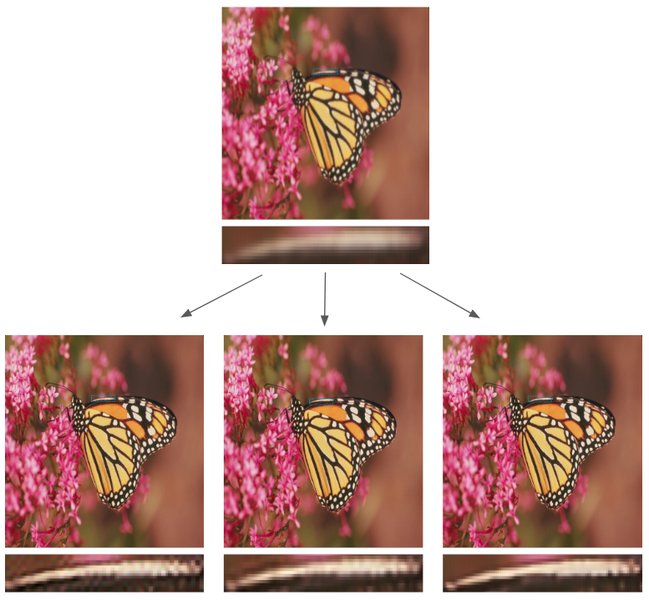

첫 번째 어려운 점은 하나의 저해상도 이미지에 대해 여러 개의 고해상도 이미지가 나올 수 있다는 것입니다. 위 그림은 1개의 저해상도 이미지(상단 이미지)에 대응하는 3개의 고해상도 이미지(하단 이미지)를 나타냈습니다. 3개의 고해상도 이미지 사이에서는 눈으로 볼 때 거의 차이를 나타내지 않지만, 아래 확대한 이미지를 보면 세부적으로 픽셀의 값이 각각 다른 것을 알 수 있죠. 하나의 저해상도 이미지를 고해상도 이미지로 만드는데 매우 다양한 경우의 수가 있다는 것은 Super Resolution이 가진 큰 특징이며, 이러한 문제를 ill-posed (inverse) problem이라 부릅니다.

일반적으로 Super Resolution 모델을 학습시키기 위한 데이터를 구성하는 과정은, 먼저 고해상도 이미지를 준비하고 특정한 처리 과정을 거쳐 저해상도 이미지를 생성하며, 생성된 저해상도 이미지를 입력으로 원래의 고해상도 이미지를 복원하도록 학습을 진행합니다.



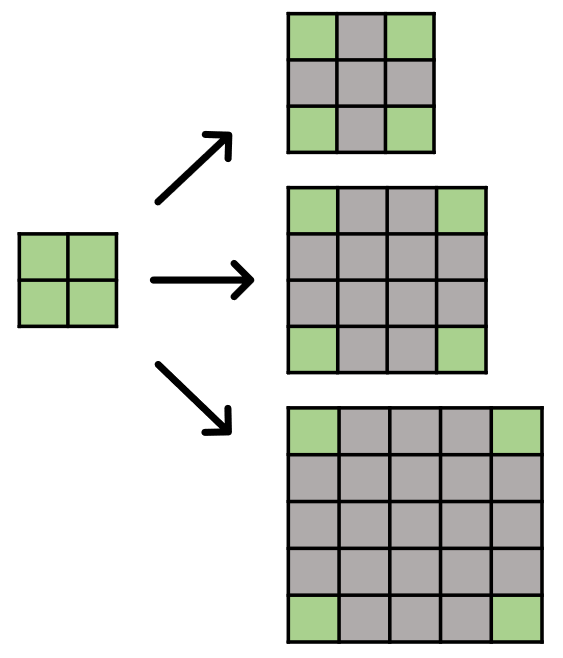

두 번째 어려운 점은 Super Resolution 문제의 복잡도입니다. 위 그림은 2x2 크기의 이미지를 이용해 3x3, 4x4, 5x5 크기의 이미지로 Super Resolution 하는 과정을 간략하게 나타냈습니다. 녹색으로 나타난 2x2 이미지 픽셀을 입력으로 3x3 크기의 이미지 만드는 경우 새롭게 생성해야 하는 정보는 최소 5개 픽셀(회색)이며, 4x4의 경우 12개, 5x5의 경우 21개의 정보를 생성해야 합니다. 원래 가진 제한된 정보(녹색 픽셀)만을 이용해 많은 정보(회색 픽셀)를 만들어내는 과정은 매우 복잡하며 그만큼 잘못된 정보를 만들어 낼 가능성 또한 높습니다. 이 문제는 원래 가진 이미지의 해상도 보다 더욱더 높은 해상도로 Super Resolution 할수록 점점 심해집니다.


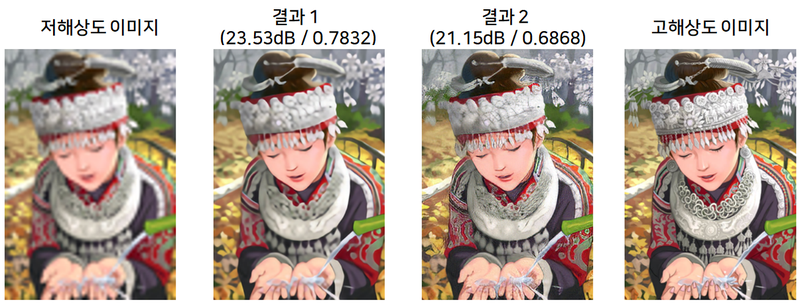

위 이미지의 첫 번째 및 네 번째 이미지는 저해상도 및 고해상도 이미지를 나타내며, 두 번째 및 세 번째 이미지는 각각 다른 딥러닝 모델을 이용해 Super Resolution 하여 생성한 결과 이미지입니다. 딥러닝 방법을 사용한 결과(두 번째 및 세 번째 이미지)를 비교한다면, 시각적으로 어떤 이미지가 더 고해상도에 가까운가요? 대부분 결과 2 이미지가 분명 더욱 세밀한 정보를 잘 표현하여 해상도가 높다고 생각할 수 있습니다. 많은 Super Resolution 연구에서 사용되는 두 개의 정량적 평가 결과가 두 번째 및 세 번째 이미지 제목에 나타나 있습니다. 결과 2의 이미지에 세밀한 정보가 잘 표현되었다고 생각했지만 실제 평가 결과는 결과 1 이미지에 쓰인 숫자가 더 높은 것을 확인할 수 있습니다. 이 평가 척도는 각각 높을수록 더 원본 이미지와 비슷함을 말하며, 정량적으로 결과 1이 더 좋은 결과라는 뜻입니다. (이러한 평가 척도에 대해서는 이후 단계에서 다루겠습니다) 마지막으로 Super Resolution을 수행하는 데 어려운 점은 위 그림과 같이 결과를 평가하는 데 있어 흔히 사용되는 정량적 평가 척도와 사람이 시각적으로 관찰하여 내린 평가가 잘 일치하지 않는다는 것입니다.

(2775, 4251, 3)


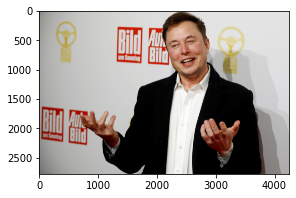

In [11]:
from skimage import data
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds



hr_image = cv2.imread(os.getenv('HOME')+'/aiffel/EXP_16_super_resolution/musk.png')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

(693, 1062, 3)


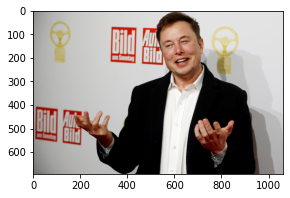

In [12]:
# 이미지 픽셀 수 줄이기 (1/4)
lr_image = cv2.resize(
    hr_image,
    dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4)
)

print(lr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(lr_image)

In [15]:
# pre-trained 모델 로드
model_file = os.getenv('HOME')+'/aiffel/EXP_16_super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [19]:
# SRGAN으로 고해상도 이미지 생성
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)  # 텐서 값을 지정된 최소값과 최대값으로 자릅니다.
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True      # as_supervised=True 옵션을 주면 dict 형태가 아닌 tuple 형태로 데이터를 return 받습니다.
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image)

ResourceExhaustedError:  OOM when allocating tensor with shape[1,2772,4248,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_3/p_re_lu_26/Relu_1-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_3677]

Function call stack:
predict_function


In [ ]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)